In [5]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from scipy.stats import norm
import math

In [6]:
guitarists = pd.read_csv('data.csv', delimiter=';', index_col=False, low_memory=False, dtype=None, header=None, names=["lastname", "firstname", "city"])

In [9]:
wroclaw_guitarist = guitarists.city.value_counts()["WROCŁAW"]
wroclaw = int(wroclaw_guitarist/100)
non_wroclaw = int((guitarists.city.size - wroclaw_guitarist)/100)

data = torch.cat((torch.ones(wroclaw), torch.zeros(non_wroclaw)))

data

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])

In [4]:
wroclaw/(wroclaw + non_wroclaw)

0.3561643835616438

In [5]:
mean = torch.mean(data)
mean

tensor(0.3562)

In [6]:
def model(data):
    alpha0 = torch.tensor(20.0)
    beta0 = torch.tensor(30.0)
    f = pyro.sample("beta", dist.Beta(alpha0, beta0))
    for i in pyro.plate("data_loop", len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])


def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(20.0), constraint=constraints.positive)
    pyro.sample("beta", dist.Beta(alpha_q, beta_q))

adam_params = {"lr": 0.0001}
optimizer = pyro.optim.Adam(adam_params)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


In [7]:
def mean_beta(alpha, beta):
    mean = alpha / (alpha + beta)
    factor = beta / (alpha * (1.0 + alpha + beta))
    std = mean * math.sqrt(factor)
    return mean, std

In [8]:
pyro.clear_param_store()

losses = []
means = []
for step in tqdm(range(10000)):
    losses.append(svi.step(data))
    alpha_q = pyro.param("alpha_q").item()
    beta_q = pyro.param("beta_q").item()
    
    inferred_mean = alpha_q / (alpha_q + beta_q)
    factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
    inferred_std = inferred_mean * math.sqrt(factor)
    means.append(inferred_mean)
    svi.step(data)


100%|██████████| 10000/10000 [05:51<00:00, 28.45it/s]


In [9]:
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

In [10]:
alpha_q, beta_q

(14.9885892868042, 24.778886795043945)

In [11]:
inferred_mean = alpha_q / (alpha_q + beta_q)
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print((inferred_mean, inferred_std))

(0.3769057220517381, 0.07589904901271453)


Text(0,0.5,'loss')

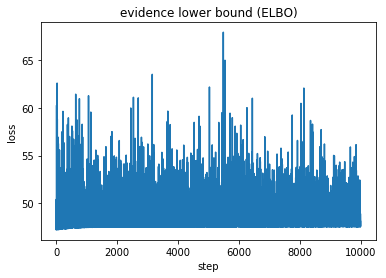

In [12]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss")

Text(0,0.5,'mean')

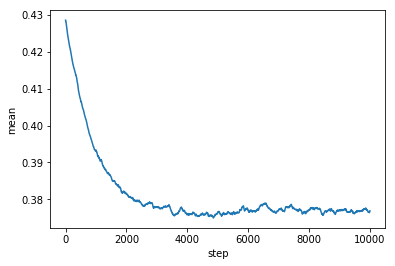

In [13]:
plt.plot(means)
plt.xlabel("step")
plt.ylabel("mean")